# adding tighter delta_phi_ll_MET cut for 0ggF


 Channel: 0ggF


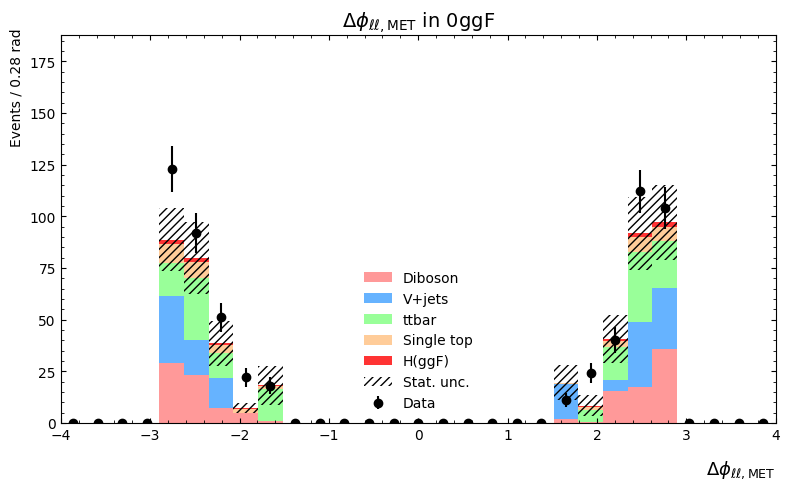

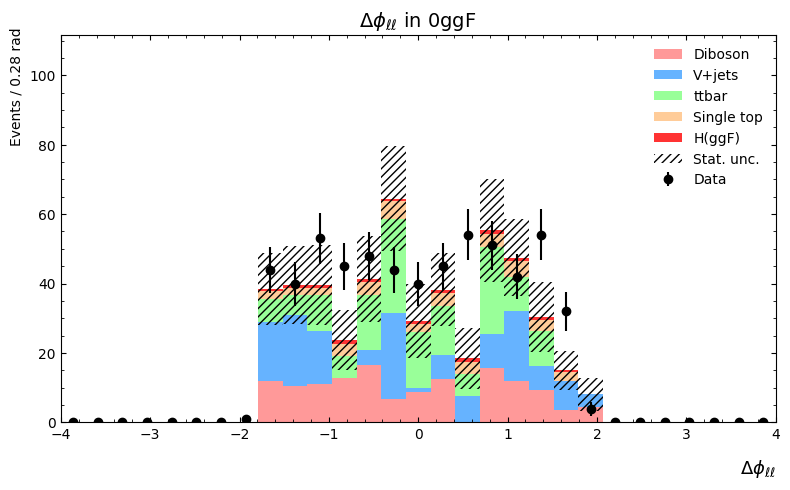

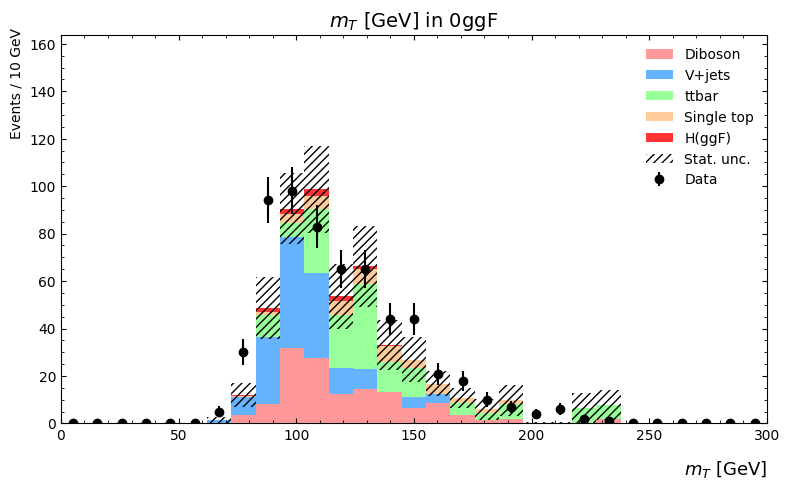

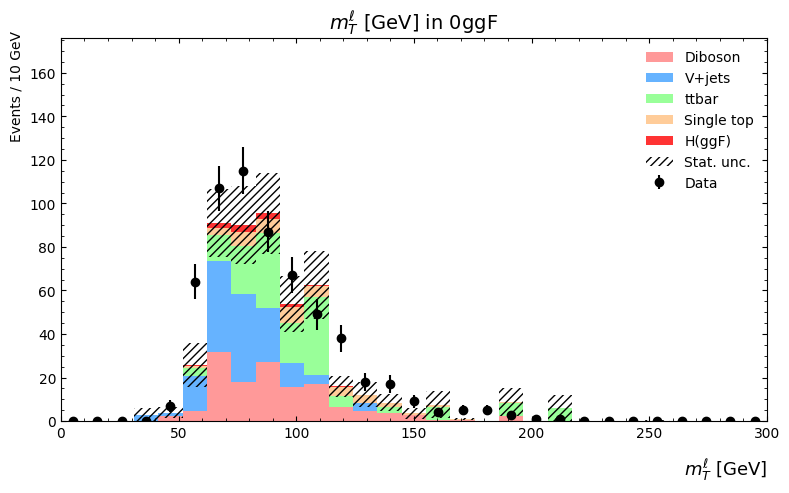

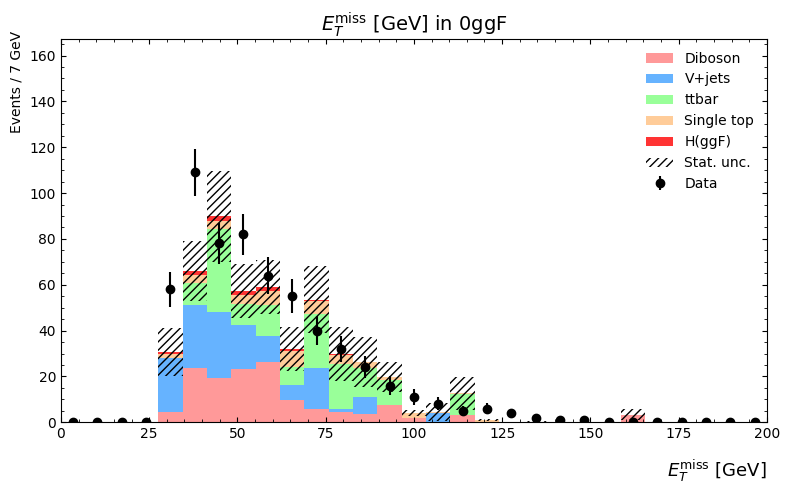

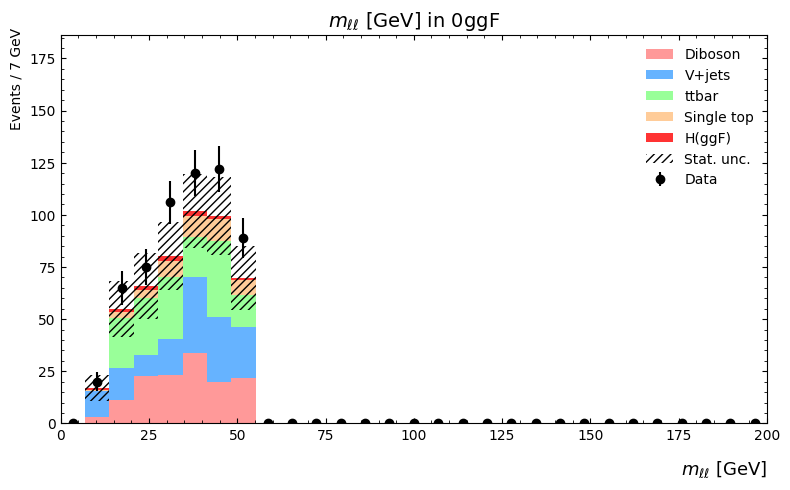

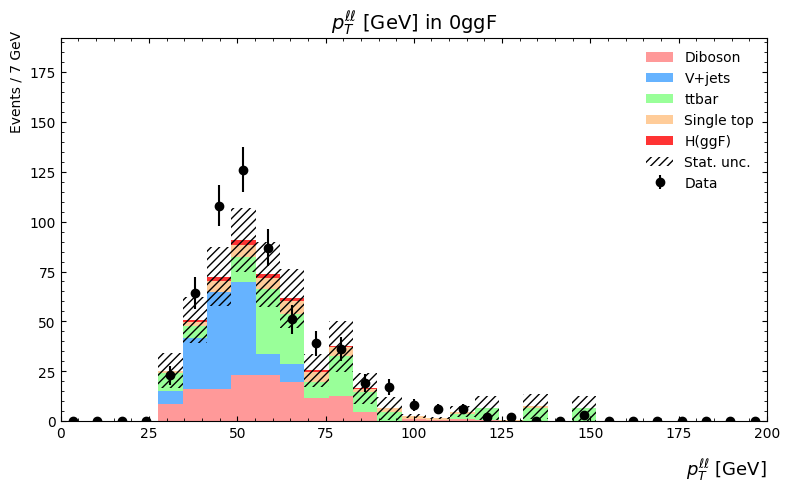

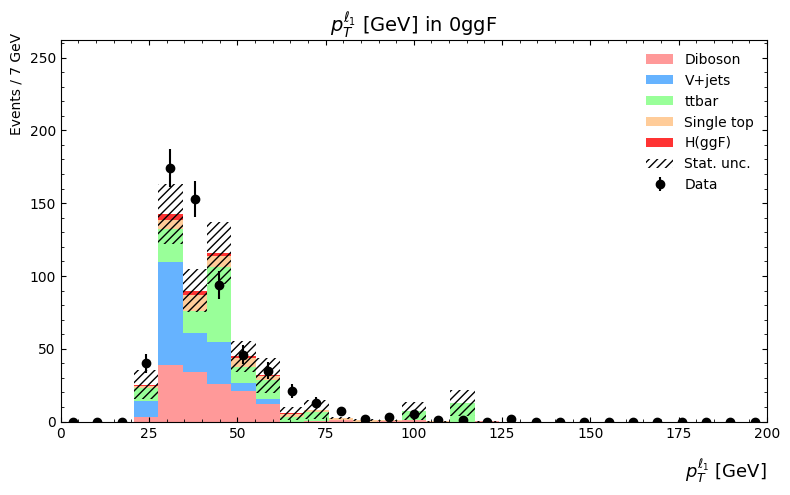

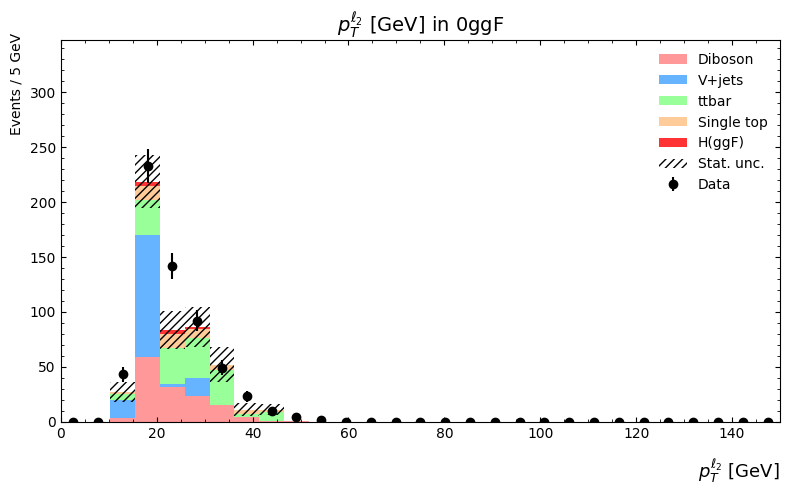

In [14]:
# import 
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 

# list of analysis channels to process (only 0ggF here since that is what the problem is for)
channels = ['0ggF']
selection_mode = "full" # SR
 
# directory where json files are stored
json_dir = "background_json_by_selection_CHECK_INCREASED"
json_dir = "background_json_by_selection_test_FULL_0ggF_new"
# directory with data json files
data_json_dir = "data_new_JSON_INCREASED"
data_json_dir = "data_json_by_selection_test_FULL_0ggF_new"

# dictionary mapping variable names to plot settings
variables_to_plot = {
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},  # scale MeV to GeV # 260, 22
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 150, 30), "scale": 1e-3},
}

# define background sample groups
group_map = {
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(ggF)": ["HWW"],
}

# assign colors
group_colors = {
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(ggF)": "#ff3333",
}

# list of sample names considered ttbar
ttbar_samples = ["ttbar_lep"]

# list of sample names considered single top
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

# load mc events from a specific background category
def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")  #path
    if not os.path.exists(filepath):  # skip if file does not exist
        return []
    with open(filepath) as f:
        content = json.load(f)  # load json data
    events = []
    for sample_name, evts in content["samples"].items():  # go over samples
        # filter based on group 
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(ggF)" and sample_name != "ggH125_WW2lep":
            continue
        events.extend(evts)  # add all events to the list
    return events

# load data events for a given channel from all periods
def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:
        content = json.load(f)  # load json file
    all_events = []
    for period_events in content["samples"].values():  # loop through run periods
        all_events.extend(period_events)  # accumulate data events
    return all_events


# now the main plot
for channel in channels:
    print(f"\n Channel: {channel}")

    for var, meta in variables_to_plot.items():  # loop over variables to plot
        bin_edges = meta["bins"]  # get bin edges
        step_size = bin_edges[1] - bin_edges[0]  # compute bin width
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # compute bin centers for plotting
        xlabel = meta["xlabel"]  # x-axis label
        scale = meta.get("scale", 1.0)  # variable scaling factor ---- NOTE this is to convert MeV to GeV NOT a weight scale!!!

        fig, ax = plt.subplots(figsize=(8, 5))  # create a figure and axes for plotting

        # initialize lists for stacked background plotting
        stack_vals = []  # variable values per group
        stack_wgts = []  # weights per group
        stack_colors = []  # colors per group
        stack_labels = []  # legend labels per group

        # make flat lists to compute total MC uncertainty
        all_mc_vals = []
        all_mc_weights = []

        # loop over groups
        for group_name, cats in group_map.items():
            group_vals, group_wgts = [], []  # temporary storage for this group
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)  # load events
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:  # handle leading/subleading pt
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt:  # case for other variables with just 1 value
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:  # if this group has events, add it to the stack
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals:  # only plot if there are mc values
            # draw stacked MC histogram
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)

            # flatten mc values and weights
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])

            # uncertainty as hatched error bands
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        # loading and plotting
        data_vals = load_data_events(channel)  # load all data events
        data_var_vals = []  # variable values from data

        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt:  # leading/subleading pt
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var in evt:  # general variable case (not the leptons)
                data_var_vals.append(evt[var] * scale)

        # histogram the data values with errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)

        # plot data points with error bars
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')  # black circles for the data

        # for the plot
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # x-axis range

        # y-axis upper limit from mc and data
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax)  # y-axis range
        # add minor tick marks
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        # tick appearance
        ax.tick_params(which='both', direction='in', top=True, right=True)
        # x-axis label
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)
        #y-axis label with bin width
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')
        ax.legend(frameon=False)
        ax.set_title(f"{xlabel} in {channel}", fontsize=14) # title
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

# only njet = 0 and bjet veto + preselection


 Channel: 0ggF


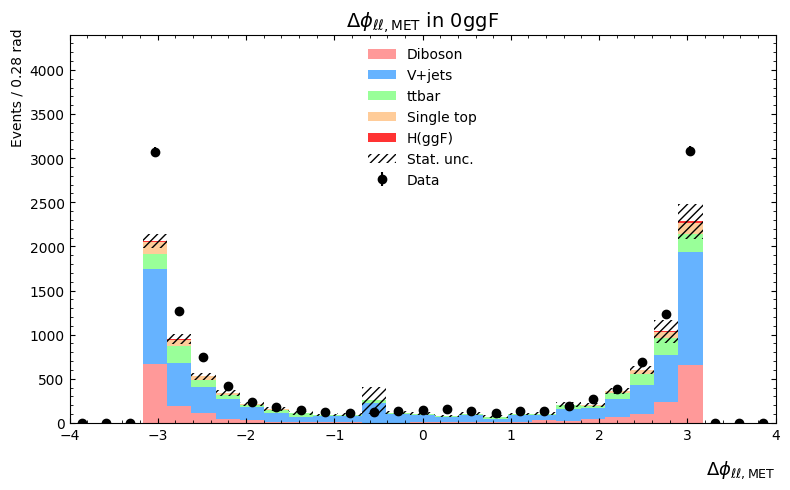

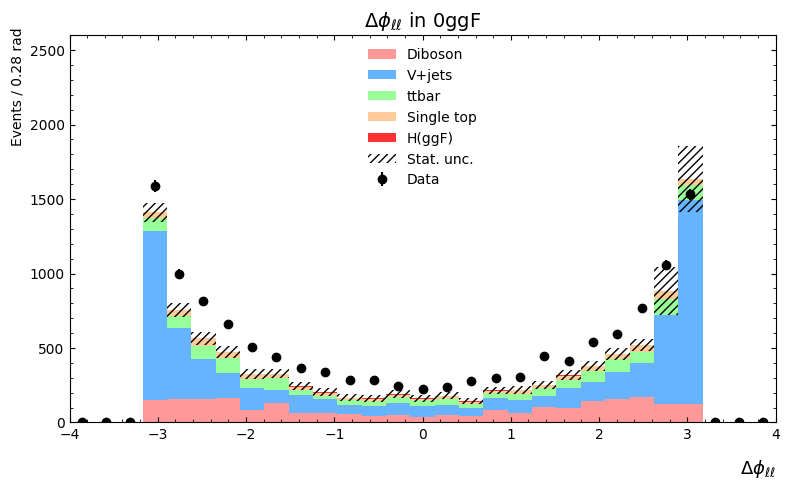

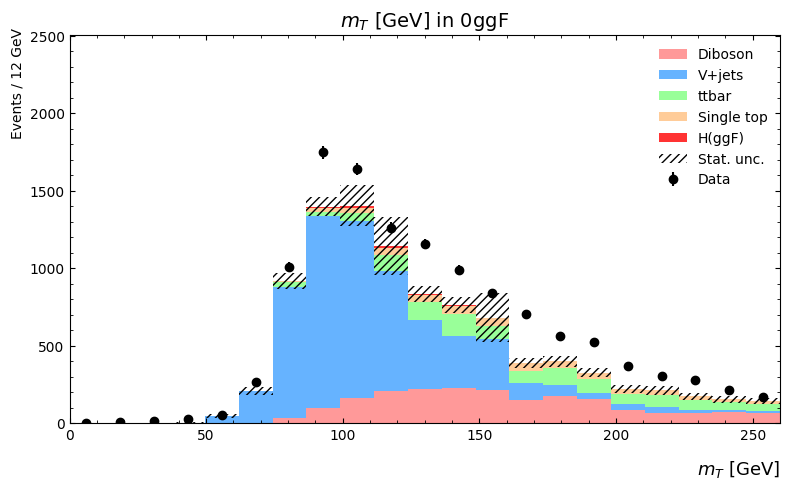

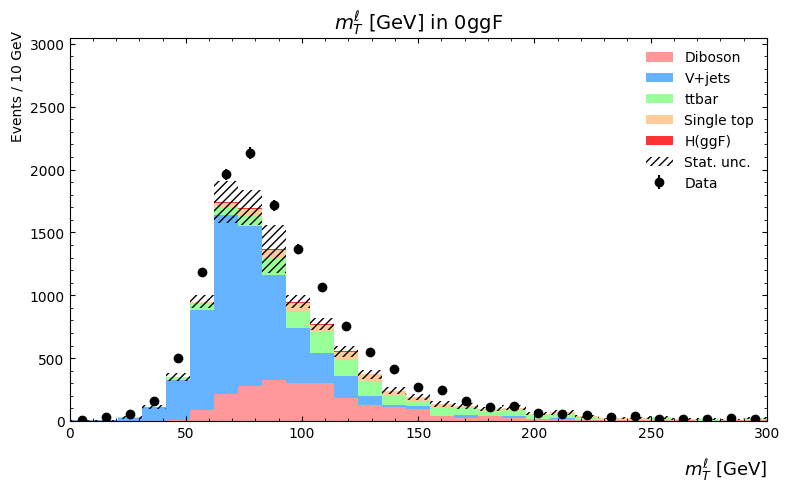

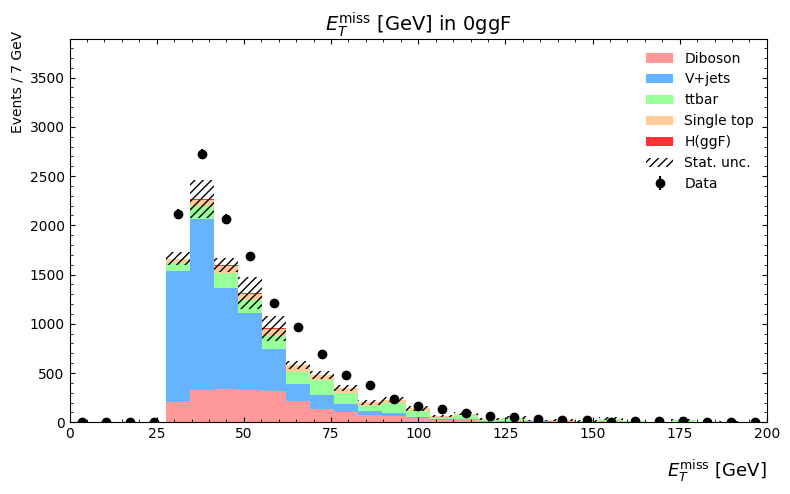

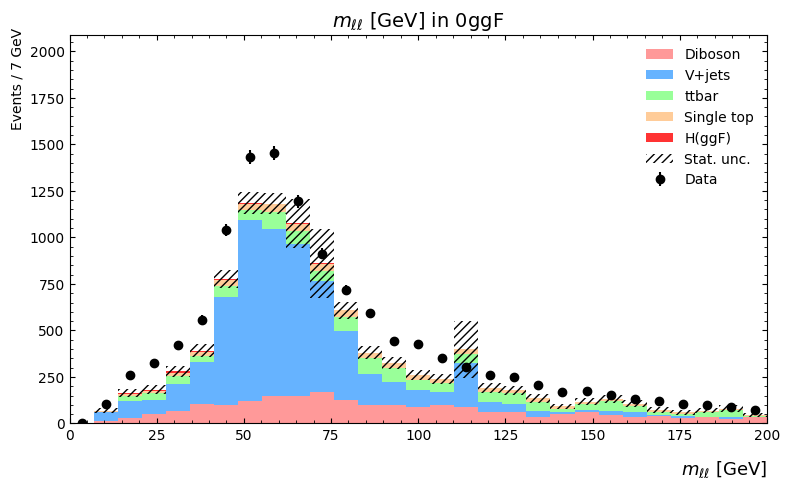

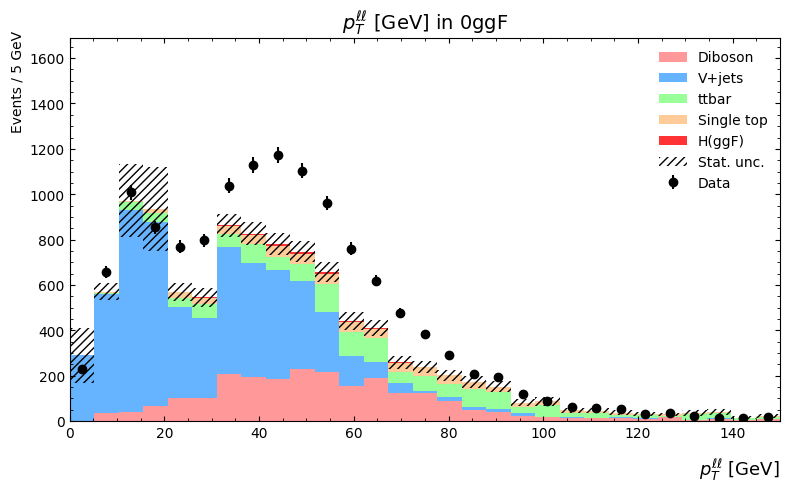

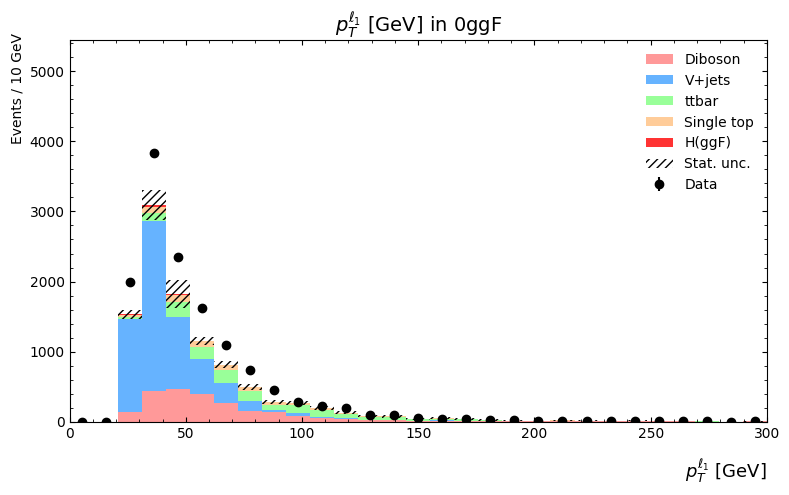

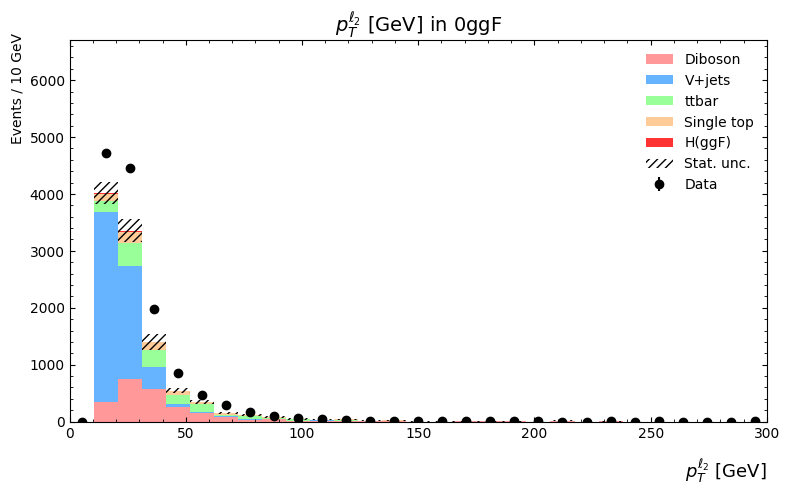

In [12]:
# NJETS = 0 cut
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator  

channels = ['0ggF']  # just looking at the 0-jet bin
selection_mode = "full"  # using full signal region selection

# directory with background mc json
json_dir = "background_json_by_selection_BACKGROUND_TEST"
json_dir = "background_json_by_selection_test_FULL_0ggF_jet"
# directory with data json files
data_json_dir = "data_json_by_selection_TESTDATA"
data_json_dir = "data_json_by_selection_test_FULL_0ggF_jet"

# dictionary of variables to plot (  binning and axis labels)
variables_to_plot = {
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 260, 22), "scale": 1e-3},  # scale MeV → GeV
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 150, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
}

# map each background group to its component categories
group_map = {
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],  # WW, WZ, ZZ etc.
    "V+jets": ["Wjets", "Zjets"],  # W+jets and Z+jets
    "ttbar": ["top"],  # will be filtered by sample name
    "Single top": ["top"],  # also filtered by sample name
    "H(ggF)": ["HWW"], 
}

# assign a unique color to each background group
group_colors = {
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(ggF)": "#ff3333",
}

# define sample names used to isolate ttbar and single top samples
ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

# load events for a given mc category and group
def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")  # path
    if not os.path.exists(filepath):  # skip if missing
        return []
    with open(filepath) as f:
        content = json.load(f)  # read json file
    events = []
    for sample_name, evts in content["samples"].items():  # loop through samples
        # apply filtering for ttbar/single top/H(ggF) based on sample name
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(ggF)" and sample_name != "ggH125_WW2lep":
            continue
        events.extend(evts)  # add valid events to the list
    return events

# load all data events across run periods for a given channel
def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")  #path
    if not os.path.exists(filepath):  # return empty if file is missing
        return []
    with open(filepath) as f:
        content = json.load(f)  # load JSON file
    all_events = []
    for period_events in content["samples"].values():  # loop over run periods
        all_events.extend(period_events)  # collect all events together
    return all_events

# loop to plot
for channel in channels:
    print(f"\n Channel: {channel}")  # print current channel
    for var, meta in variables_to_plot.items():  # iterate over all variables
        bin_edges = meta["bins"]  # x-axis bin edges
        step_size = bin_edges[1] - bin_edges[0]  # bin width
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # center of each bin
        xlabel = meta["xlabel"]  # label for x-axis
        scale = meta.get("scale", 1.0)  # scale 1

        fig, ax = plt.subplots(figsize=(8, 5))  # make a plot

        # lists for stacking each mc group separately
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        # lists for calculating total MC distribution and error
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # loop through background groups
            group_vals, group_wgts = [], []  # reset for this group
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)  # get MC events
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:  # dealing with the two leptons
                        i = int(var[-1])  # get index (0 or 1)
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)  # sort leptons by pT
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))  # use the weights
                    elif var in evt:  # regular case
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:  # skip empty groups
                stack_vals.append(group_vals)  # values for histogram
                stack_wgts.append(group_wgts)  # weights for histogram
                stack_colors.append(group_colors[group_name])  # group color
                stack_labels.append(group_name)  # group label
                all_mc_vals.append(group_vals)  # for total stack
                all_mc_weights.append(group_wgts)

        # plot stacked MC histogram if we have any data
        if stack_vals:
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)

            # compute stacked MC totals and error per bin
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])

            # add uncertainty on the plot
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        # load data points 
        data_vals = load_data_events(channel)  # get all data events
        data_var_vals = []  # container for selected variable values

        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # dealing with the two leptons
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var in evt:
                data_var_vals.append(evt[var] * scale)

        # make histogram for data points and errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)

        # plot the data as black points with error bars
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # plotting (how it looks)
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # x-axis range

        # choose y-axis upper limit based on highest content
        ymax = max(max(mc_totals + mc_errors, default=0),
                   max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax)
        ax.xaxis.set_minor_locator(AutoMinorLocator())  # add minor ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)  # axis ticks inward
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # x-axis label
        # make y-axis label with bin width and correct unit
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')
        ax.legend(frameon=False)  # legend without border
        ax.set_title(f"{xlabel} in {channel}", fontsize=14) 
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92) 
        plt.show() 

# only Njet = 1 + bjet veto and preselection


 Channel: 1ggF


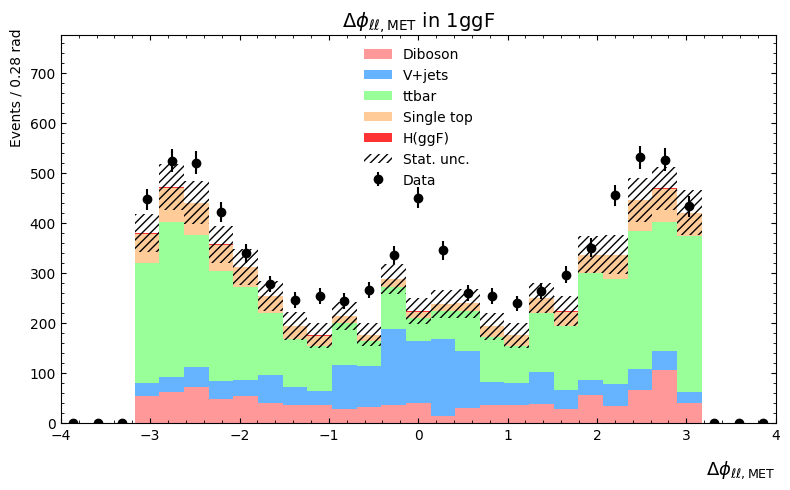

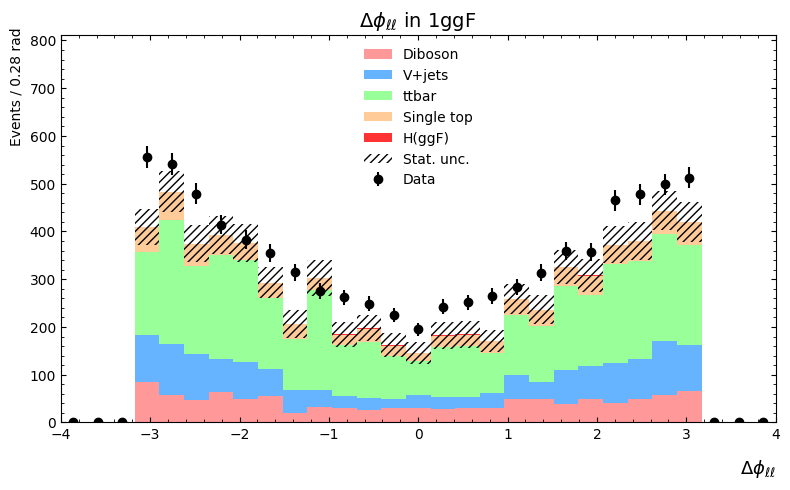

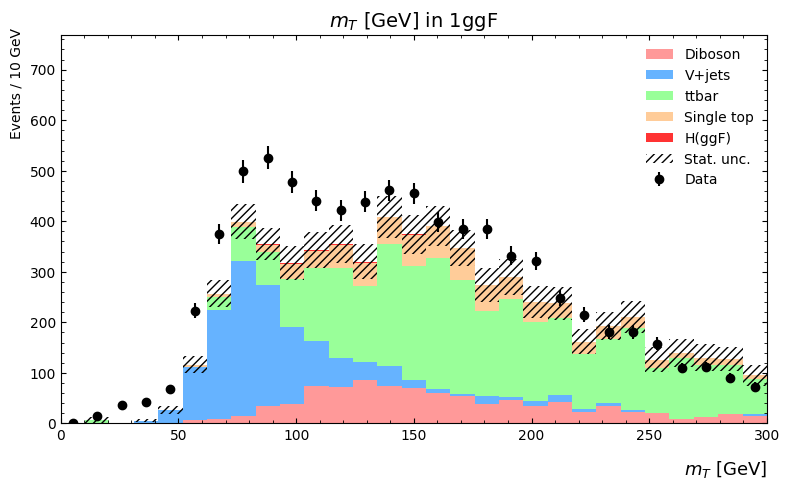

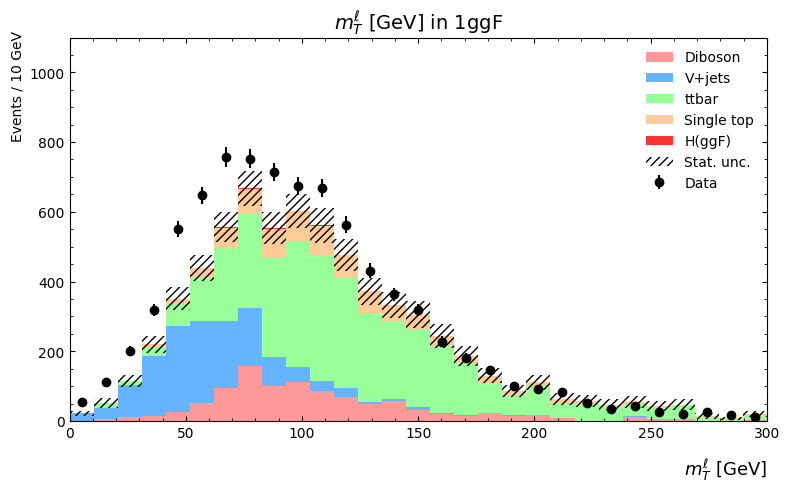

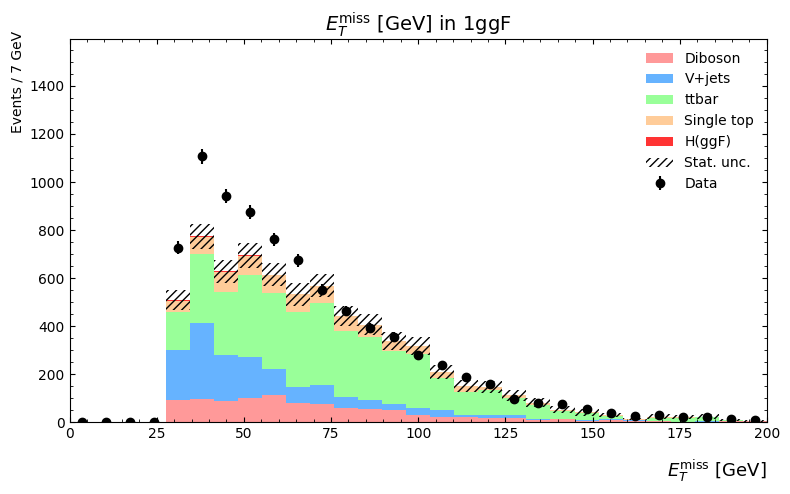

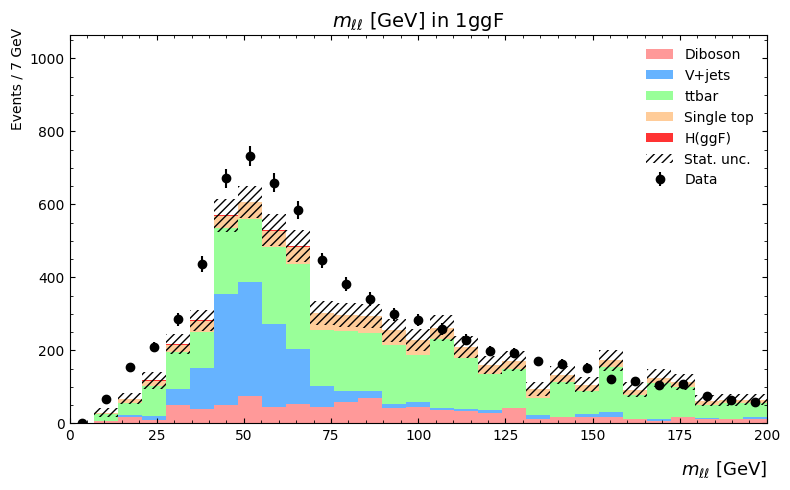

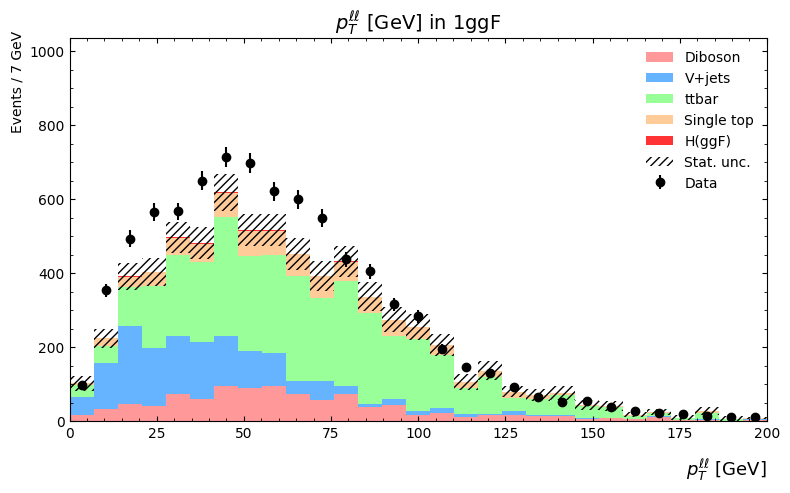

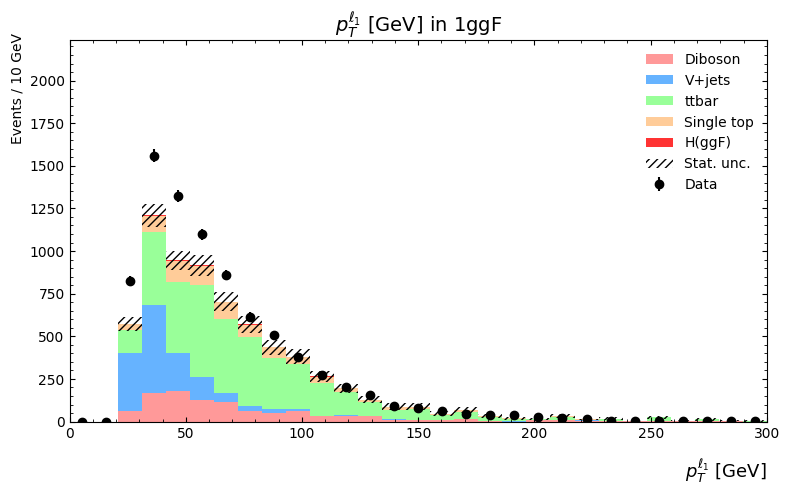

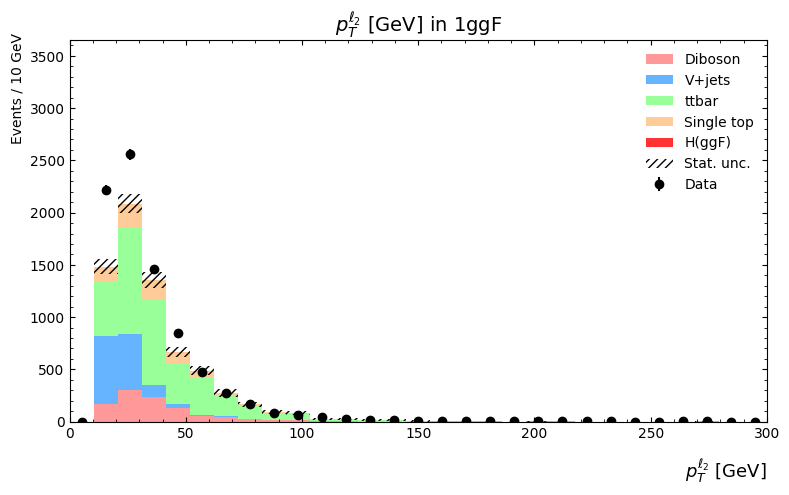

In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 

channels = ['1ggF']  # use the 1-jet category
selection_mode = "full"  # SR
# directory with mc json files
json_dir = "background_json_by_selection_BACKGROUND_TEST_1ggF"
json_dir = "background_json_by_selection_test_FULL_1ggF_jet"
# directory with data json files
data_json_dir = "data_json_by_selection_TESTDATA_1ggF"
data_json_dir = "data_json_by_selection_test_FULL_1ggF_jet"

# dictionary of variables to plot ( x-axis label and binning)
variables_to_plot = {
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},  # the "scale" convert MeV to GeV for the plots
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
}

# map each process to its json categories
group_map = {
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"],
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(ggF)": ["HWW"],
}

# colors to each group for stacked plotting
group_colors = {
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(ggF)": "#ff3333",
}

# names of ttbar samples to include
ttbar_samples = ["ttbar_lep"]
# names of single top samples to include
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

# function to load events from a json file for a given group and category
def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")  # path
    if not os.path.exists(filepath):  # skip if file doesn't exist
        return []
    with open(filepath) as f:
        content = json.load(f)  # read the json
    events = []
    for sample_name, evts in content["samples"].items():  # go over each sample in the file
        # apply filtering for specific group sample names
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(ggF)" and sample_name != "ggH125_WW2lep":
            continue
        events.extend(evts)  # add events to the list
    return events

# function to load all data events for a given channel (combines run periods)
def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")  # full path to file
    if not os.path.exists(filepath):  # skip if not found
        return []
    with open(filepath) as f:
        content = json.load(f)
    all_events = []
    for period_events in content["samples"].values():  # combine events from each run period
        all_events.extend(period_events)
    return all_events

# loop to plot
for channel in channels:
    print(f"\n Channel: {channel}")  
    for var, meta in variables_to_plot.items():  # loop through all variables to plot
        bin_edges = meta["bins"]  # x-axis bin edges
        step_size = bin_edges[1] - bin_edges[0]  # width of each bin
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # center of each bin for plotting markers
        xlabel = meta["xlabel"]  # get x-axis label
        scale = meta.get("scale", 1.0)  # use scale (CONVERTS MeV to GeV, NOT a weight scale)

        fig, ax = plt.subplots(figsize=(8, 5)) 

        # containers for stacked histogram input
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        # containers for computing mc error
        all_mc_vals, all_mc_weights = [], []
        for group_name, cats in group_map.items():  # loop through each group 
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)  # load mc events
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:  # dealing with the two leptons
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)  # sort leptons by pt
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)  # apply scale
                            group_wgts.append(evt.get("weight", 1.0))  # gets the weight
                    elif var in evt:  # for variables that don't have multiple values in a single event
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:  # if group has any entries, append for plotting
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals:  # stacked histogram if any MC content exists
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)

            # flatten all mc values 
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])

            # overlay uncertainty
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        # loading data
        data_vals = load_data_events(channel)  # load data for this channel
        data_var_vals = []  # store selected variable values for each event

        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt:  # deal with the two leptons
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var in evt:  # variable with just one value
                data_var_vals.append(evt[var] * scale)

        # bin the data values and errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        # overlay data points with error bars
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')  # black circles

        # stuff to make the plot look better
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # fix x-axis range
        # choose y-axis max from mc or data total
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax)  # set y-axis range

        ax.xaxis.set_minor_locator(AutoMinorLocator())  # minor ticks on x-axis
        ax.yaxis.set_minor_locator(AutoMinorLocator())  # minor ticks on y-axis
        ax.tick_params(which='both', direction='in', top=True, right=True)  # inward ticks
        # x-axis label
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)
        # y-axis label with bin width and unit
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')
        # legend and title
        ax.legend(frameon=False)
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()